In [3]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

np.random.seed(42)

In [4]:
df = pd.read_csv('../cyberbullying_tweets.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

df.head()

Dataset shape: (47692, 2)

Columns: ['tweet_text', 'cyberbullying_type']


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
print(f"Class distribution:\n{df['cyberbullying_type'].value_counts()}")
print(f"Number of unique classes: {df['cyberbullying_type'].nunique()}")

Class distribution:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64
Number of unique classes: 6


In [6]:
def _remove_emojis(s):
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F]"
        "|[\U0001F300-\U0001F5FF]"
        "|[\U0001F680-\U0001F6FF]"
        "|[\U0001F1E0-\U0001F1FF]"
        "|[\U00002700-\U000027BF]"
        "|[\U0001F900-\U0001F9FF]"
        "|[\U00002600-\U000026FF]",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(" ", s)


def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = text.replace("#", "")
    text = _remove_emojis(text)
    text = re.sub(r"_+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

df['processed_text'] = df['tweet_text'].apply(preprocess_text)

In [7]:
X = df['processed_text']
y = df['cyberbullying_type']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 33383
Validation set size: 4770
Test set size: 9539


In [8]:
word_vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

char_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=2
)

X_train_word = word_vectorizer.fit_transform(X_train)
X_train_char = char_vectorizer.fit_transform(X_train)

X_val_word = word_vectorizer.transform(X_val)
X_val_char = char_vectorizer.transform(X_val)

X_test_word = word_vectorizer.transform(X_test)
X_test_char = char_vectorizer.transform(X_test)

X_train_tfidf = hstack([X_train_word, X_train_char])
X_val_tfidf = hstack([X_val_word, X_val_char])
X_test_tfidf = hstack([X_test_word, X_test_char])

svm_model = LinearSVC(random_state=42, max_iter=10000)
svm_model.fit(X_train_tfidf, y_train)

y_val_pred = svm_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Results:")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Results:
Validation Accuracy: 0.8329
Validation Classification Report:
                     precision    recall  f1-score   support

                age       0.96      0.98      0.97       800
          ethnicity       0.98      0.97      0.98       796
             gender       0.90      0.86      0.88       797
  not_cyberbullying       0.59      0.56      0.57       795
other_cyberbullying       0.61      0.64      0.63       782
           religion       0.95      0.97      0.96       800

           accuracy                           0.83      4770
          macro avg       0.83      0.83      0.83      4770
       weighted avg       0.83      0.83      0.83      4770



In [9]:
y_pred = svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8193
Test Classification Report:
                     precision    recall  f1-score   support

                age       0.97      0.98      0.98      1598
          ethnicity       0.97      0.97      0.97      1592
             gender       0.88      0.86      0.87      1595
  not_cyberbullying       0.56      0.53      0.54      1589
other_cyberbullying       0.57      0.60      0.59      1565
           religion       0.96      0.95      0.96      1600

           accuracy                           0.82      9539
          macro avg       0.82      0.82      0.82      9539
       weighted avg       0.82      0.82      0.82      9539



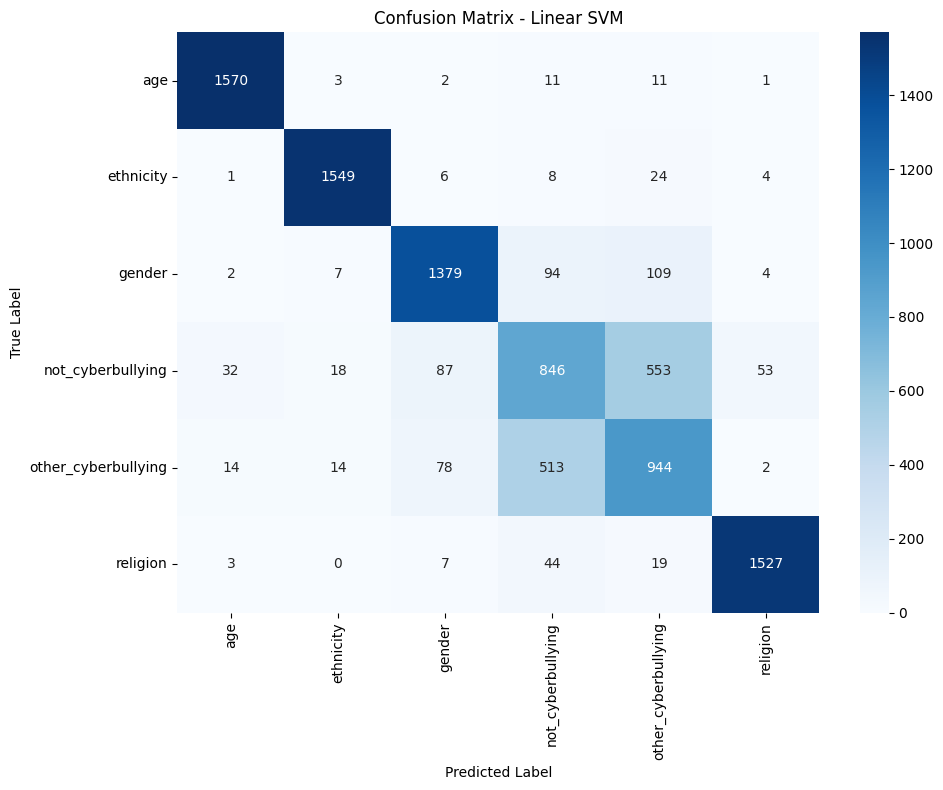

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm_model.classes_, 
            yticklabels=svm_model.classes_)
plt.title('Confusion Matrix - Linear SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
